# Visualizing Facebook message data

I'm unsure of whether this is the most appropriate use of Jupyter notebooks or not but I am using it anyway. I appreciate that I am able to explain my thought process both for my later self and for whoever might have happened upon this. Plus, I'm excited to use this for my future projects so let's start simple.

In [1]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS

Facebook data is UTF-8 encoded but decoded as Latin-1.
To fix this, we need to re-encode as Latin-1 and decode again as UTF-8.
Something something mojibake something. Below, we use 'fix_hex_string' to fix the nonsense and remove all punctuation from strings except for apostrophes.

In [2]:
def fix_hex_string(s):
	return re.sub(r'[\xc2-\xf4][\x80-\xbf]+', lambda m: m.group(0).encode('latin1').decode('utf8'), s)

Quick sidenote: lambda is the coolest thing ever.

Another note: I didn't address casing in clean_data because I typically write in all lowercase. Removing phrases with casing first and then lowering will mean a smaller possibility of losing meaningful content.

In [3]:
def clean_data(raw_data):
    for message in raw_data['messages']:
        if 'content' in message:
            message['content'] = fix_hex_string(message['content'])
            message['content'] = re.sub(r'’',"'",message['content']) # two kinds of apostrophes in text, replace
            message['content'] = re.sub(r'[^\w\'<\s]+','',message['content']) 
            # remove all punctuation except apostrophe (and < because of <3s lol)
            # feels like there should be a more concise way to do this^
    return

The data includes text content for each file, photo, sticker, GIF, etc. exchanged. This text is structured as, "PersonA sent a(n) [object here]." 
This skews data by increasing instances of "you, PersonA, sent" and the various objects so we remove rows with these messages. 

The following function needs to be changed for improved generalizability(?). Depending on an individual's typing style, this could remove meaningful messages and not just some stickers. Need to find out how to do something along the lines of "You called *." and "* called you."

Differentiating between phrases that start and end a message helps but does not eliminate the possibility of above occuring but this overrides the previous filter.

In [4]:
def create_dataframes(cleaned_data):
    columns_list = ['timestamp_ms','sender_name','content']
    filter_phrases = ['You missed a call from','You missed a video chat with','The video chat ended',\
                      'You called ', 'You are now connected on Messenger', 'missed your call',\
                      'missed your video chat', 'sent a voice message', 'sent a photo', 'sent a link',\
                      'sent a video', 'sent a sticker', 'sent a GIF', 'sent an attachment',\
                      'sent a live location', 'sent an event link', 'called you']
    
    df = pd.DataFrame(data=cleaned_data['messages'], columns=columns_list)
    filtered_df = df[df.content.str.contains('|'.join(filter_phrases)) == False] 

    return df, filtered_df

In [5]:
def generate_common_words_bar_graph(filtered_message_data):
    # create series of all words used and get respective counts
    all_words = pd.Series(' '.join(filtered_message_data['content']).lower().split()).value_counts()
    
    # creating new dataframe to sort by count and removing low value words
    word_count_df = pd.DataFrame({'Count':all_words.values}, index=all_words.index)
    
    useless_words = ['u', 'lol', 'im', 'yeah', 'ya', 'oh', 'ye']
    for word in useless_words:
        STOPWORDS.add(word)
    word_count_df = word_count_df[word_count_df.index.isin(STOPWORDS)==False]
    
    word_count_df[:50].plot(
        kind='barh', 
        title='Most Commonly Used Words', 
        figsize=(12, 15), 
        fontsize=14, 
        legend=False
    )
    
    return

In [6]:
def generate_wordcloud(filtered_message_data):
    text = filtered_message_data['content'].str.cat(sep = '\n').lower()
    
    useless_words = ['u', 'im', 'yeah', 'ya', 'oh', 'ye']
    for word in useless_words:
        STOPWORDS.add(word)
    
    wordcloud = WordCloud(
        width=1500, 
        height=1500, 
        max_font_size=400, 
        stopwords=STOPWORDS,
        collocations=False
    ).generate(text)
    
    plt.figure(figsize=(80,80))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return

In [7]:
def messages_exchanged_per(message_data, frequency):
    
    message_data['timestamp'] = message_data.apply(lambda x: pd.to_datetime(x['timestamp_ms'], unit='ms')\
                                .tz_localize(tz='UTC', ambiguous=True).tz_convert(tz='America/Toronto'), axis=1)
    
    figure, ax = plt.subplots(figsize=(16,10))
    sender_grouped_data = message_data.groupby([pd.Grouper(key='timestamp',freq=frequency), 'sender_name'])
    histogram = sender_grouped_data['content'].count()
    data = histogram.unstack()
    
    prev_plt = None
    for name in data:
        if prev_plt is not None:
            plt.bar(data.index, data[name], width=5, bottom=data[prev_plt]).set_label(name)
        else:
            plt.bar(data.index, data[name], width=5).set_label(name)
            prev_plt = name
    
    plt.legend()
    ax.get_xticks()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    figure.autofmt_xdate()
    

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


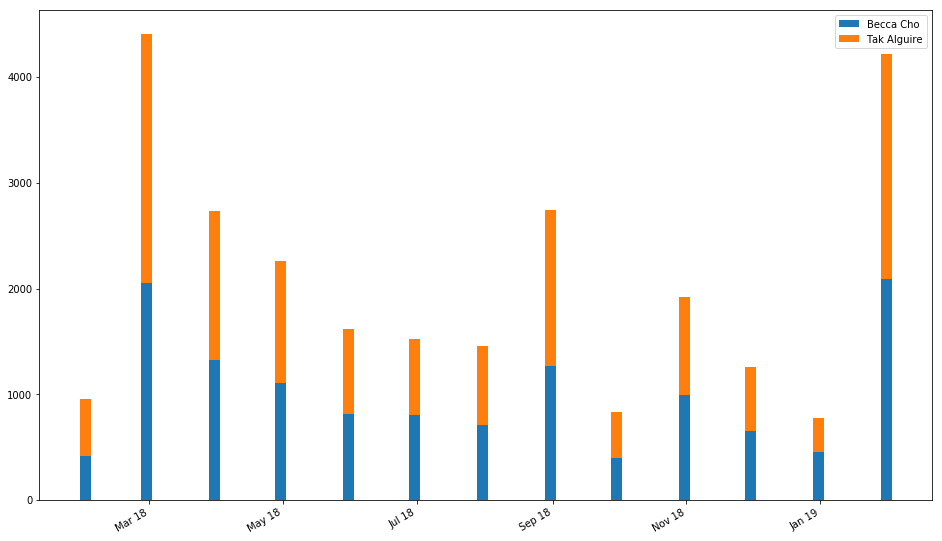

In [8]:
file_name = '/Users/rebeccacho/Desktop/Messages/TakAlguire_ncyVNGMZQw/message.json'

with open(file_name, 'r') as file:
    data_dump = json.load(file)

clean_data(data_dump) # clean encoding and punctuation
message_df, filtered_message_df = create_dataframes(data_dump) # filtered_df removes stickers/attachments/etc.

#generate_common_words_bar_graph(filtered_message_df)
#generate_wordcloud(filtered_message_df) # later implement image-colouring
messages_exchanged_per(message_df, "M")